In [1]:
import sys
import os

package_path = '..'
if package_path not in sys.path:
    sys.path.append(package_path)

In [2]:
%load_ext autoreload
%autoreload 2

# Main NoteBook

In [3]:
from src.analyzer.core import DataAnalyzer
from src.config.config import load_config
config = load_config()
config

ExpConfig(runs=[132, 136, 137], param=ExpParams(hutch=<Hutch.EH1: 'eh1'>, detector=<Detector.JUNGFRAU2: 'jungfrau2'>, xray=<Xray.HARD: 'HX'>, pump_setting=<Hertz.THIRTY: '30HZ'>, x1=0, x2=1, y1=2, y2=3, sdd=1.3, dps=7.5e-05, beam_energy=9.7, sigma_factor=1, wavelength=1.2781876127134046), path=ExpPaths(load_dir='Y:\\240608_FXS\\raw_data\\h5\\type=raw', save_dir='Y:\\240608_FXS\\raw_data\\h5\\type=raw', param_dir='Y:\\240608_FXS\\raw_data\\h5\\type=raw\\DataParameter', image_dir='Y:\\240608_FXS\\raw_data\\h5\\type=raw\\Image', mat_dir='Y:\\240608_FXS\\raw_data\\h5\\type=raw\\Mat_files2', npz_dir='Y:\\240608_FXS\\raw_data\\h5\\type=raw\\Npz_files', tif_dir='Y:\\240608_FXS\\raw_data\\h5\\type=raw\\Tif_files'))

In [4]:
def get_npz_file_name(run, scan, config, comment=None):
    npz_dir: str = config.path.npz_dir
    file_name: str = f"run={run:0>4}_scan={scan:0>4}"
    if comment is not None:
        file_name += comment
    return os.path.join(npz_dir, file_name + ".npz")

In [5]:
run: int = 149
scan: int = 1
print(f"RUN={run:0>3}, SCAN={scan:0>3}")

RUN=149, SCAN=001


In [6]:
npz_file: str = get_npz_file_name(run, scan, config)
analyzer = DataAnalyzer(npz_file)

poff_images = analyzer.poff_images
pon_images = analyzer.pon_images

print(f"{poff_images.shape = }")
print(f"{pon_images.shape = }")

poff_images.shape = (60, 514, 1030)
pon_images.shape = (60, 514, 1030)


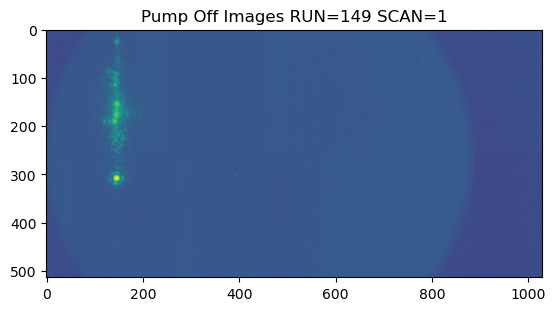

In [7]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1)
ax.imshow(np.log1p(poff_images.sum(axis=0)))
ax.set_title(f"Pump Off Images RUN={run} SCAN={scan}");

In [8]:
from roi_rectangle import RoiRectangle


roi_rect = RoiRectangle(100, 250, 220, 370)
roi_poff_images = roi_rect.slice(poff_images)
roi_pon_images = roi_rect.slice(pon_images)

print(f"ROI: x1={roi_rect.x1}, y1={roi_rect.y1}, x2={roi_rect.x2}, y2={roi_rect.y2}")
print(f"Roi Pump Off Images Shape: {roi_poff_images.shape}")
print(f"Roi Pump On Images Shape: {roi_pon_images.shape}")
print(f"{roi_rect.width = }, {roi_rect.height = }")

ROI: x1=100, y1=250, x2=220, y2=370
Roi Pump Off Images Shape: (60, 120, 120)
Roi Pump On Images Shape: (60, 120, 120)
roi_rect.width = 120, roi_rect.height = 120


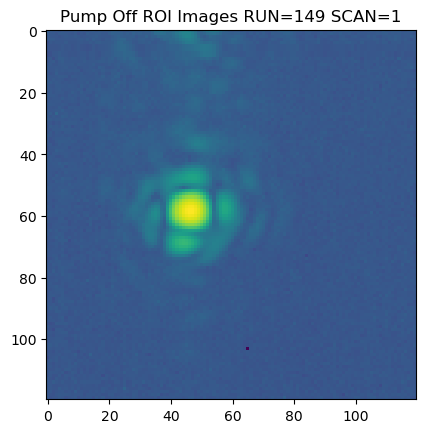

In [9]:
fig, ax = plt.subplots(1, 1)
ax.imshow(np.log1p(roi_poff_images.sum(axis=0)))
ax.set_title(f"Pump Off ROI Images RUN={run} SCAN={scan}");

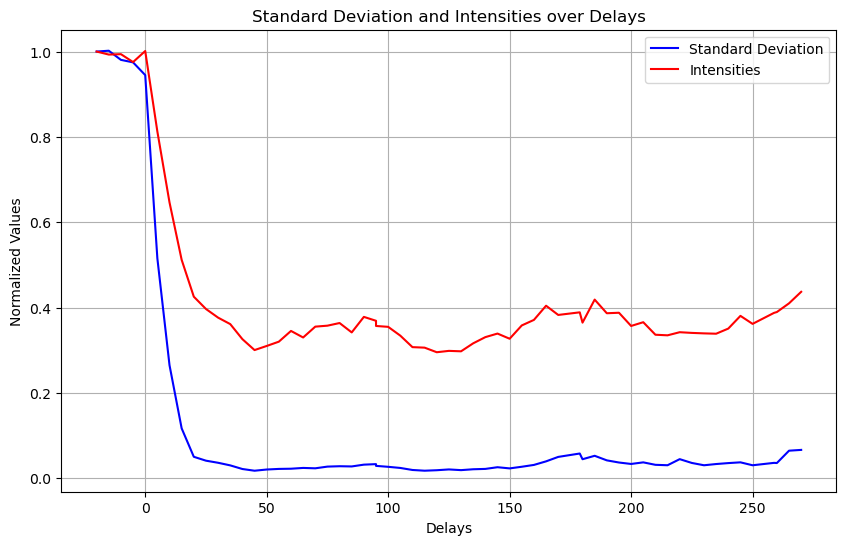

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

delays = analyzer.delay
stds = np.std(roi_pon_images, axis=(1,2))
# vars = np.var(roi_pon_images, axis=(1,2))
intensities = np.sum(roi_pon_images, axis=(1,2))

ax.plot(delays, stds / stds[0], label='Standard Deviation', color='b')
# ax.plot(delays, vars / vars[0], label='variance', color='k')
ax.plot(delays, intensities / intensities[0], label='Intensities', color='r')

ax.set_title('Standard Deviation and Intensities over Delays')
ax.set_xlabel('Delays')
ax.set_ylabel('Normalized Values')

# ax.set_xlim(50, None)
ax.legend()
ax.grid(True);

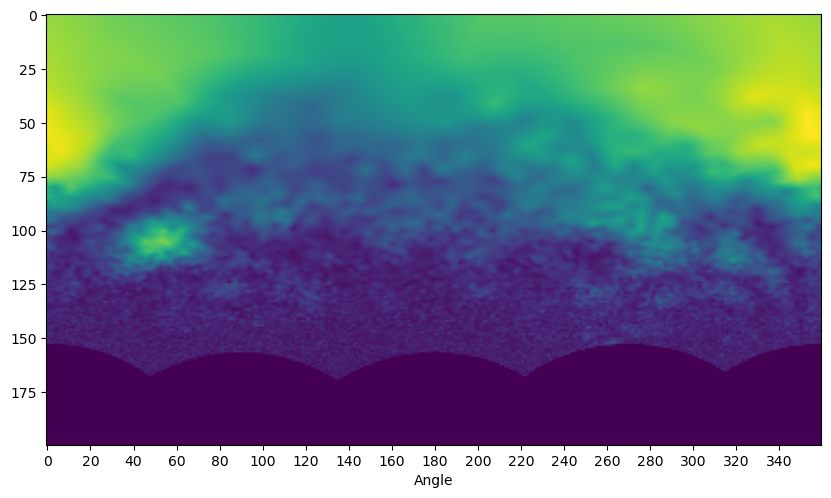

In [11]:
from skimage.transform import warp_polar
from skimage.measure import moments

# image = roi_pon_images.sum(axis=0)
image = roi_pon_images[-1]
m = moments(image, order=1)
x_com = m[1, 0] / m[0, 0]
y_com = m[0, 1] / m[0, 0]

warped = warp_polar(image, center=(x_com, y_com) ,scaling='log', radius=200)
warped_image = warped.T
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.imshow(np.log1p(warped_image))
ax.set_xlabel('Angle')

x_ticks = np.arange(0, warped_image.shape[1], 20)
ax.set_xticks(x_ticks)

plt.show()

In [47]:
power_run = {
    1: 37,
    2: 38,
    3: 39,
    4: 40,
    5: 41,
    6: 42,
    7: 43,
    8: 44,
    9: 45,
    10: 46,
    15: 47,
    20: 48
}

In [48]:
power_run_2 = {
    6: 92,
    8: 91,
    10: 90,
    11: 89,
    12: 88,
    13: 87,
    14: 86,
    15: 85, # 79, 85
    16: 80,
    17: 81,
    18: 82,
    19: 83,
    20: 84
}

In [58]:
import pandas as pd
from src.utils.file_util import get_run_scan_directory
power_com_x = {}
power_com_y = {}
image_dir: str = config.path.image_dir
for power, run_num in power_run.items():
    data_file = os.path.join(get_run_scan_directory(image_dir, run_num, 1), "data.csv")
    data_df = pd.read_csv(data_file)
    power_com_x[power] = data_df["poff_com_x"].values - data_df["pon_com_x"].values
    power_com_y[power] = data_df["poff_com_y"].values - data_df["pon_com_y"].values
delays = data_df.index.values

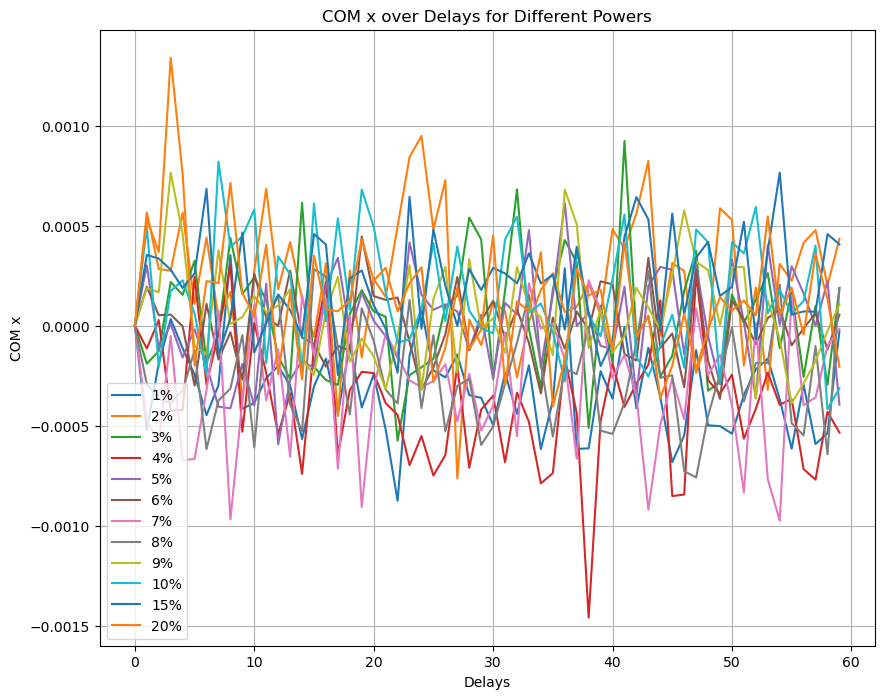

In [59]:
fig, ax = plt.subplots(figsize=(10, 8))

for i, (power, com_x) in enumerate(power_com_x.items()):
    ax.plot(delays, com_x, label=f'{power}%')

# 제목 추가
ax.set_title('COM x over Delays for Different Powers')

# 축 레이블 추가
ax.set_xlabel('Delays')
ax.set_ylabel('COM x')

# 범례 추가
ax.legend()

# 그리드 추가
ax.grid(True)

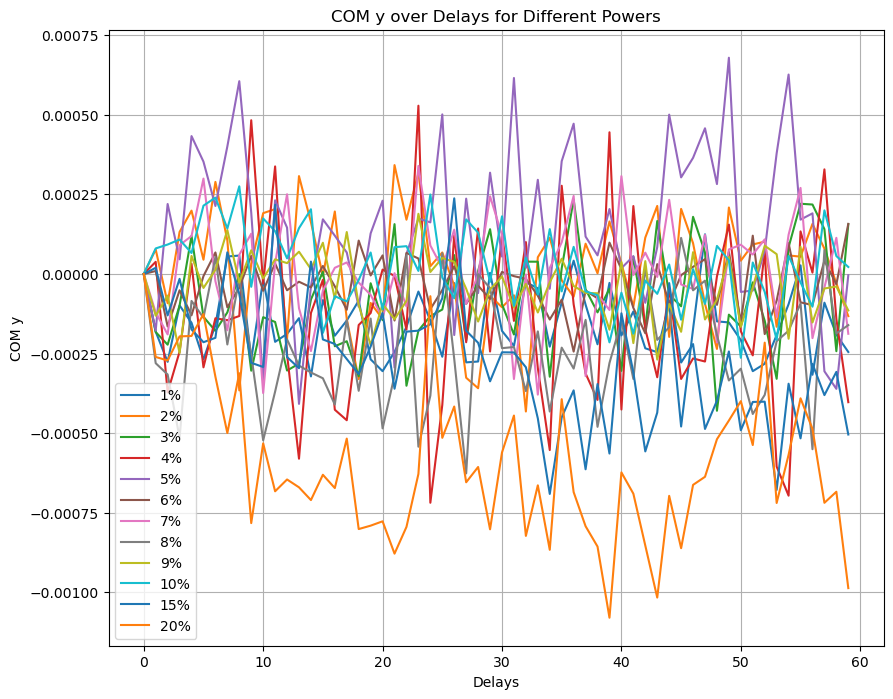

In [60]:
fig, ax = plt.subplots(figsize=(10, 8))

for i, (power, com_y) in enumerate(power_com_y.items()):
    color = colors[i % len(colors)]
    ax.plot(delays, com_y, label=f'{power}%')

# 제목 추가
ax.set_title('COM y over Delays for Different Powers')

# 축 레이블 추가
ax.set_xlabel('Delays')
ax.set_ylabel('COM y')

# 범례 추가
ax.legend()

# 그리드 추가
ax.grid(True)